<a href="https://colab.research.google.com/github/Oleksii-Adamov/rcpsp-qaoa/blob/main/RCPSP_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install amazon-braket-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.7/191.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 7.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144548 sha256=3bdc32cd671b9462fc

In [2]:
from matplotlib import pyplot as plt
from functools import partial
import networkx as nx
import itertools
import scipy
import numpy as np
import json, os, requests, time
from getpass import getpass
from google.colab import userdata
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.circuits.circuit import subroutine
from braket.devices import LocalSimulator
from braket.parametric import FreeParameter
from braket.ir.jaqcd import Program, H, CNot, Rx, Rz, ZZ
from scipy.optimize import minimize
import pickle
from datetime import datetime
import pylab as pl
from matplotlib import collections  as mc

#Problem digitalization (e.g input data for RCPSP)

In [3]:
# activies numeration should start from 1

# real_num_activities = 3
# T = 10
# precedence_graph_edges = np.array([[2, 3], [1, 3]])
# activity_processing_time = np.array([1, 1, 2])
# resourse_capacity = np.array([3, 3])
# resourse_consumption = np.array([[1, 2], [0, 3], [1, 1]])
# number_of_recourses = resourse_capacity.shape[0]

real_num_activities = 4
T = 4
precedence_graph_edges = np.array([[1, 2], [3, 4], [2, 4]])
activity_processing_time = np.array([1, 1, 2, 1])
resourse_capacity = np.array([4, 4])
resourse_consumption = np.array([[4, 0], [2, 1], [1, 2], [3, 3]])
number_of_recourses = resourse_capacity.shape[0]

# real_num_activities = 5
# T = 10
# precedence_graph_edges = np.array([[1, 2], [3, 4], [2, 5], [4, 5]])
# activity_processing_time = np.array([1, 1, 1, 1, 1])
# resourse_capacity = np.array([4, 4])
# resourse_consumption = np.array([[2, 1], [2, 3], [3, 0], [2, 2], [4, 2]])
# number_of_recourses = resourse_capacity.shape[0]

Add dummy activities

In [4]:
def add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption):
    num_activities = real_num_activities
    starting_activity = None
    end_activity = None

    has_outcoming = [False] * (real_num_activities+1)
    has_incoming = [False] * (real_num_activities+1)
    for edge in precedence_graph_edges:
        has_outcoming[int(edge[0])] = True
        has_incoming[int(edge[1])] = True
    # mark 0 index True, so it won't be counted
    has_incoming[0] = True
    has_outcoming[0] = True
    to_insert_start_activity = has_incoming.count(False) > 1
    to_insert_end_activity = has_outcoming.count(False) > 1
    for i in range(1, real_num_activities+1):
        if to_insert_end_activity and not has_outcoming[i]:
            precedence_graph_edges = np.concatenate([precedence_graph_edges, [[i, real_num_activities+1]]])
        if not to_insert_start_activity and not has_incoming[i]:
            starting_activity = i
        if not to_insert_end_activity and not has_outcoming[i]:
            end_activity = i

    if to_insert_end_activity:
        print("inserted end activity")
        num_activities += 1
        activity_processing_time = np.concatenate([activity_processing_time, [0]])
        resourse_consumption = np.concatenate([resourse_consumption, [[0] * number_of_recourses]])
        end_activity = real_num_activities+1

    # shift numeration to be from zero
    if not starting_activity is None:
        starting_activity -= 1
    end_activity -= 1
    for edge in precedence_graph_edges:
        edge[0] -= 1
        edge[1] -= 1

    return num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity

In [5]:
num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity = add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption)

In [6]:
end_activity

3

In [7]:
starting_activity is None

True

In [8]:
print(num_activities)

4


In [9]:
print(precedence_graph_edges)

[[0 1]
 [2 3]
 [1 3]]


In [10]:
print(activity_processing_time)

[1 1 2 1]


In [11]:
print(resourse_consumption)

[[4 0]
 [2 1]
 [1 2]
 [3 3]]


#Calculating time windows

In [12]:
def longest_paths_in_postive_graph(G, weigth_func):
    # find shortest path for -G, O(V+E)
    topological_order = list(nx.topological_sort(G)) # Kahn's algorithm (incoming degrees), O(V+E)
    # all incoming weights are non-negative, because of reverse sign of weights, zero weight path is max
    shortest_path = np.full_like(activity_processing_time, 0)
    for node in topological_order:
        for neighbor in G[node]:
            if not neighbor is None and shortest_path[neighbor] > shortest_path[node] - weigth_func(node, neighbor):
                shortest_path[neighbor] = shortest_path[node] - weigth_func(node, neighbor)
    return -shortest_path

In [13]:
def calculate_time_windows(precedence_graph_edges, end_activity):
    # calculate earliest start
    # by finding longest paths from source (start activity) to every node, weights - activity processing time
    precedence_graph_edges_with_start_activity = np.copy(precedence_graph_edges)
    if starting_activity is None:
        precedence_graph_edges_with_start_activity = np.concatenate([[np.array([-1, i]) for i in range(0, num_activities)], precedence_graph_edges_with_start_activity])
    G = nx.from_edgelist(precedence_graph_edges_with_start_activity, create_using=nx.DiGraph)
    nx.draw(G, with_labels=True)
    earliest_start = longest_paths_in_postive_graph(G, lambda u, v: activity_processing_time[u] if u > -1 else 0)
    # calculate latest start
    latest_start = np.full_like(activity_processing_time, 0)
    for activity in range(0, num_activities):
        descendants = []
        if G.has_node(activity):
            descendants = nx.descendants(G, activity)
        for activity2 in range(0, num_activities):
            if not (activity2 in descendants):
                latest_start[activity] += activity_processing_time[activity2]
        latest_start[activity] = min(T, latest_start[activity])

    return earliest_start, latest_start

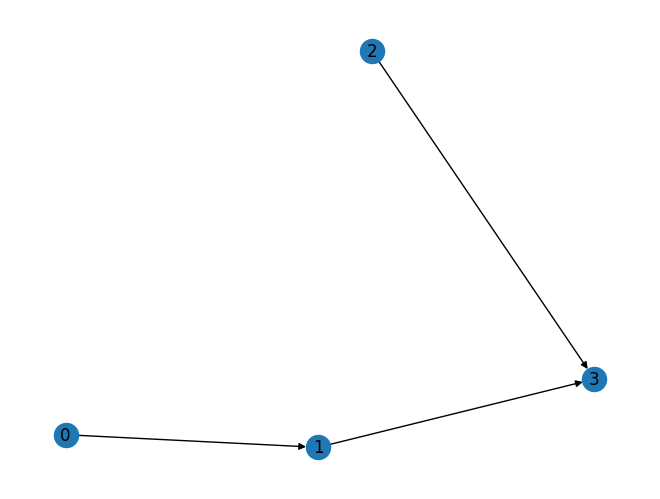

In [14]:
G = nx.from_edgelist(precedence_graph_edges, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

[0 1 0 2]
[3 4 4 4]


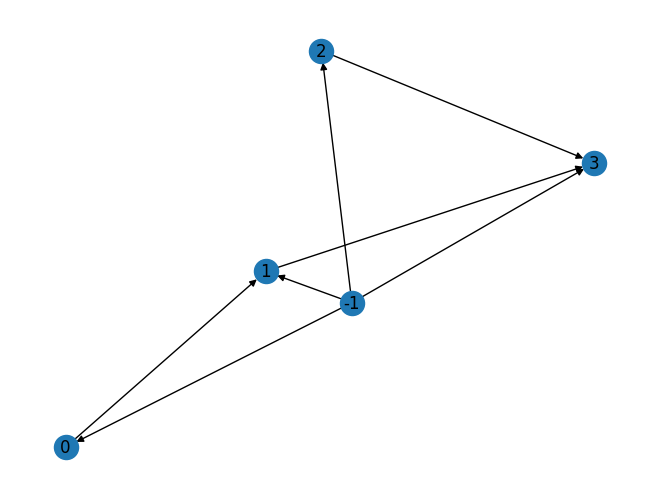

In [15]:
earliest_start, latest_start = calculate_time_windows(precedence_graph_edges, end_activity)
T = latest_start[end_activity]
print(earliest_start)
print(latest_start)

# QUBO variables, objective and penalties

## Variables

In [16]:
number_of_activities_variables = 0
for i in range(0, num_activities):
    number_of_activities_variables += latest_start[i] - earliest_start[i] + 1

In [17]:
number_of_variables = number_of_activities_variables

In [18]:
number_of_variables

16

In [19]:
activity_time_index_start = np.empty_like(activity_processing_time)
cur_index = 0
for i in range(0, num_activities):
    activity_time_index_start[i] = cur_index
    cur_index += latest_start[i] - earliest_start[i] + 1

In [20]:
def activity_time_to_index(activity_index, time_index):
    assert(time_index >= earliest_start[activity_index] and time_index <= latest_start[activity_index])
    return activity_time_index_start[activity_index] + time_index - earliest_start[activity_index]

In [21]:
def from_index_to_activity_time(index):
    for i in range(0, num_activities):
        if index >= activity_time_index_start[i] and index <= activity_time_index_start[i] + latest_start[i] - earliest_start[i]:
            return i, earliest_start[i] + index - activity_time_index_start[i]

## Objective function

In [22]:
def add_objective_function(Q, last_activity):
    for t in range(earliest_start[last_activity], latest_start[last_activity]+1):
        i = activity_time_to_index(num_activities - 1, t)
        Q[i, i] += t

## Each activity starts 1 time constraint

In [23]:
def add_activity_one_start_penalty(Q, offset, penalty_coef):
    for activity in range(0, num_activities):
        for t1 in range(earliest_start[activity], latest_start[activity]+1):
            for t2 in range(earliest_start[activity], latest_start[activity]+1):
                i = activity_time_to_index(activity, t1)
                j = activity_time_to_index(activity, t2)
                if i > j:
                    i, j = j, i
                Q[i, j] += penalty_coef
            i = activity_time_to_index(activity, t1)
            Q[i, i] -= 2*penalty_coef
    offset += num_activities * penalty_coef
    return offset

## Precedence constraint

In [24]:
def add_precedence_penalty(Q, penalty_coef):
    for edge in precedence_graph_edges:
        from_activity = edge[0]
        to_activity = edge[1]
        for t1 in range(earliest_start[from_activity], latest_start[from_activity]+1):
            for t2 in range(earliest_start[to_activity], min(t1 + activity_processing_time[from_activity], latest_start[to_activity]+1)):
                i = activity_time_to_index(from_activity, t1)
                j = activity_time_to_index(to_activity, t2)
                if i > j:
                    i, j = j, i
                Q[i, j] += penalty_coef

## Unbalanced Resource constraints

In [25]:
def add_unbalanced_resourse_penalty(Q, offset, penalty_coef1, penalty_coef2):
    for t in range(0, latest_start[end_activity]+1):
        for k in range(0, number_of_recourses):
            for i1 in range(0, num_activities):
                for i2 in range(0, num_activities):
                    for r1 in range(max(t - activity_processing_time[i1] + 1, earliest_start[i1]), min(t, latest_start[i1])+1):
                        for r2 in range(max(t - activity_processing_time[i2] + 1, earliest_start[i2]), min(t, latest_start[i2])+1):
                            i = activity_time_to_index(i1, r1)
                            j = activity_time_to_index(i2, r2)
                            if i > j:
                                i, j = j, i
                            Q[i, j] += penalty_coef2 * resourse_consumption[i1, k] * resourse_consumption[i2, k]
            for i1 in range(0, num_activities):
                for r in range(max(t - activity_processing_time[i1] + 1, earliest_start[i1]), min(t, latest_start[i1])+1):
                    i = activity_time_to_index(i1, r)
                    Q[i, i] += (penalty_coef1 - 2 * resourse_capacity[k]  * penalty_coef2) * resourse_consumption[i1, k]
            offset += penalty_coef2 * resourse_capacity[k] ** 2 - penalty_coef1 * resourse_capacity[k]
    return offset

# QUBO formation

In [26]:
def form_RCPSP_QUBO(resourse_penalty1, resourse_penalty2):
    Q = np.zeros((number_of_variables, number_of_variables))
    qubo_offset = 0.0
    add_objective_function(Q, end_activity)
    qubo_offset = add_unbalanced_resourse_penalty(Q, qubo_offset, resourse_penalty1, resourse_penalty2)
    one_start_penalty = abs(max(Q.min(), Q.max(), key=abs)) * 2
    precedence_penalty = one_start_penalty
    qubo_offset = add_activity_one_start_penalty(Q, qubo_offset, one_start_penalty)
    add_precedence_penalty(Q, precedence_penalty)
    return Q, qubo_offset, one_start_penalty, precedence_penalty

In [27]:
resourse_penalty1, resourse_penalty2 = 0.11, 0.0833 # for more than 4 activities
if real_num_activities < 5:
    resourse_penalty1, resourse_penalty2 = 0.53, 0.125

In [28]:
Q, qubo_offset, one_start_penalty, precedence_penalty = form_RCPSP_QUBO(resourse_penalty1, resourse_penalty2)

# To Ising

In [29]:
def from_Q_to_Ising(Q, offset):
    ising_offset = np.copy(offset)
    n_var = len(Q)  # Get the number of variables in the QUBO matrix

    h = np.zeros((n_var))
    J = np.zeros((n_var, n_var))

    # Loop over each variable in the QUBO matrix
    for i in range(n_var):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[i] -= Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        ising_offset += Q[i, i] / 2
        # Loop over other variables to calculate pairwise interactions
        for j in range(i + 1, n_var):
            # Update the pairwise interaction strength (J) between variables i and j
            J[i, j] += Q[i, j] / 4
            # Update the magnetic fields for variables i and j based on their interactions in Q
            h[i] -= Q[i, j] / 4
            h[j] -= Q[i, j] / 4
            # Update the offset based on the interaction strength between variables i and j
            ising_offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, ising_offset

In [30]:
h, J, ising_offset = from_Q_to_Ising(Q, qubo_offset)

# IONQ simulator

In [31]:
# If your API key is stored as "IONQ_API_KEY" in your local environment, this
# should find it. Otherwise you'll be prompted to enter your API key manually.

api_key = os.getenv('IONQ_API_KEY') or userdata.get('IONQ_API_KEY') or getpass('Enter your IonQ API key: ')

ionq_api_headers = {
    "Authorization": f"apiKey {api_key}",
    "Content-Type": "application/json",
}

In [32]:
def submit_job(headers, data):
    url = "https://api.ionq.co/v0.3/jobs"
    response = requests.post(url, headers=headers, data=data)
    response_json = response.json()
    assert response.status_code == 200, f"Error: {response_json.get('message', 'Unknown error')}"
    return response_json["id"]

def query_job(job_id, headers):
    url = f"https://api.ionq.co/v0.3/jobs/{job_id}"
    response = requests.get(url, headers=headers)
    response_json = response.json()
    assert response.status_code == 200, f"Error: {response_json.get('message', 'Unknown error')}"
    return response_json["status"]

def get_job_results(job_id, headers):
    url = f"https://api.ionq.co/v0.3/jobs/{job_id}/results"
    response = requests.get(url, headers=headers, params={"sharpen": False})
    response_json = response.json()
    assert response.status_code == 200, f"Error: {response_json.get('message', 'Unknown error')}"
    return response_json

In [33]:
def ionq_api_request_data(instructions, n_qubits, shots, name):
    program = Program(instructions=instructions)
    json_program = json.loads(program.json())
    instructions_json_list = json_program["instructions"]
    for instruction in instructions_json_list:
        gate = instruction["type"]
        del instruction["type"]
        instruction["gate"] = gate
        if "angle" in instruction:
            instruction["rotation"] = instruction["angle"]
            del instruction["angle"]
    request_data = {
        "name": name,
        "shots": shots,
        "target": "simulator",
        "noise": {
            "model": "aria-1"
        },
        "error_mitigation": {"debias": True},
        "input": {
            "format": "ionq.circuit.v0",
            "gateset": "qis",
            "qubits": n_qubits,
            "circuit": json_program["instructions"]
        }
    }
    return request_data

In [34]:
def ionq_api_submit_and_get_result(request_data):
    job_id = submit_job(ionq_api_headers, json.dumps(request_data))

    # And wait for the job to be run.

    status = "ready"
    while status != "completed":
        time.sleep(1)  # wait for 1 second before querying again
        status = query_job(job_id, ionq_api_headers)

    return get_job_results(job_id, ionq_api_headers)

In [35]:
def int_to_binary_numpy_array(integer, num_of_bits):
    return np.array([(integer >> i) & 1 for i in range(num_of_bits)[::-1]])

In [36]:
def hist_to_counts(hist_results, num_of_bits, shots):
    counts = []
    for key, val in hist_results.items():
        counts.append((int_to_binary_numpy_array(int(key), num_of_bits), val * shots))
    return counts

def ionq_sim_process_result(ionq_sim_result, h_ising, J_ising, shots):
    expect_val = 0
    minimal_energy = None
    optimal_string = None
    qubits = h_ising.shape[0]
    counts = hist_to_counts(ionq_sim_result, qubits, shots)
    measurments = np.empty((shots, qubits))
    shot_index = 0
    for count in counts:
        num_samples = int(np.round(count[1]))
        if num_samples > 0:
            measurments[shot_index:shot_index+num_samples] = count[0]
            shot_index += num_samples

    meas_ising = -2*measurments + 1
    all_energies = np.diag(meas_ising @ J_ising @ meas_ising.T) + meas_ising @ h_ising
    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    optimal_string = meas_ising[np.argmin(all_energies)]
    energy_expect = np.sum(all_energies) / shots
    return energy_expect, energy_min, optimal_string

# QAOA

## Helpers

In [37]:
def is_np_array_in_list(val, array_list):
    for array in array_list:
        if np.allclose(array, val):
            return True
    return False

In [38]:
known_optimal_solutions = [] # you could use bruteforce below to find them
# example:
# known_optimal_solutions = [-2*opt_x+1 for opt_x in opt_solutions]

In [39]:
if real_num_activities == 4: # the testing one
    known_optimal_solutions = [-2*np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])+1,
    -2*np.array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])+1]

In [40]:
def save_tracker_to_file(tracker):
    # store results: dump output to pickle with timestamp in filename
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    results_file = 'results-'+time_now+'.pkl'
    print(f'Writing results to file: {results_file}')
    pickle.dump(tracker, open(results_file, "wb"))

## Circuit instructions

In [41]:
def mixer_layer_instructions(beta, n_qubits, instructions):
    """
    mixer Hamiltonian U(Hb, beta)
    """

    # apply parametrized rotation around x to every qubit
    for qubit in range(n_qubits):
        instructions.append(Rx(target=qubit, angle=2 * beta))


def cost_layer_instructions(gamma, n_qubits, h_ising, J_ising, instructions):
    """
    evolution with cost Hamiltonian
    """

    for qubit in range(h_ising.shape[0]):  # single-qubit terms
        if abs(h_ising[qubit]) > 1e-3:
            instructions.append(Rz(target=qubit, angle=2 * gamma * h_ising[qubit]))

    # two-qubit terms
    for qubit1 in range(0, J_ising.shape[0]):
        for qubit2 in range(qubit1 + 1, J_ising.shape[1]):
            #print(J_ising[qubit1, qubit2])
            if abs(J_ising[qubit1, qubit2]) > 1e-3:
                #instructions.append(ZZ(targets=[qubit1, qubit2], angle=2 * gamma * J_ising[qubit1, qubit2]))
                instructions.append(CNot(control=qubit1, target=qubit2))
                instructions.append(Rz(target=qubit2, angle=2 * gamma * J_ising[qubit1, qubit2]))
                instructions.append(CNot(control=qubit1, target=qubit2))


def qaoa_circuit_instructions(params, n_qubits, h_ising, J_ising):
    """
    function to return QAOA instructions
    """

    instructions = []

    for qubit in range(n_qubits):
        instructions.append(H(target=qubit))

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add QAOA circuit layer blocks
    for mm in range(circuit_length):
        cost_layer_instructions(gammas[mm], n_qubits, h_ising, J_ising, instructions)
        mixer_layer_instructions(betas[mm], n_qubits, instructions)
    return instructions

## Circuit

In [42]:
@subroutine(register=True)
def mixer_layer(beta, n_qubits):
    """
    Returns circuit for mixer Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    # apply parametrized rotation around x to every qubit
    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2 * beta)
        circ.add(gate)

    return circ


@subroutine(register=True)
def cost_layer(gamma, n_qubits, h_ising, J_ising):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    for qubit in range(h_ising.shape[0]):  # single-qubit terms
        if abs(h_ising[qubit]) > 1e-3:
            gate = Circuit().rz(qubit, 2 * gamma * h_ising[qubit])
            circ.add(gate)

    # two-qubit terms
    for qubit1 in range(0, J_ising.shape[0]):
        for qubit2 in range(qubit1 + 1, J_ising.shape[1]):
            if abs(J_ising[qubit1, qubit2]) > 1e-3:
                gate = Circuit().zz(qubit1, qubit2, angle=2 * gamma * J_ising[qubit1, qubit2])
                circ.add(gate)

    return circ

@subroutine(register=True)
def qaoa_circuit(params, device, n_qubits, h_ising, J_ising):
    """
    function to return full QAOA circuit
    """

    circ = Circuit()

    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add QAOA circuit layer blocks
    for mm in range(circuit_length):
        circ.cost_layer(gammas[mm], n_qubits, h_ising, J_ising)
        circ.mixer_layer(betas[mm], n_qubits)

    return circ

## Cost function

In [43]:
# function that computes cost function for given params
def cost_function(params, qaoa_circuit, h_ising, J_ising, device, n_shots, tracker, verbose):
    """
    cost function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    if verbose:
        print("==================================" * 2)
        print("Calling the quantum circuit. Cycle:", tracker["count"])

    # create parameter dict
    params_dict = {str(fp): p for fp, p in zip(qaoa_circuit.parameters, params)}

    # execute depending on whether the backend is local or cloud based

    if isinstance(device, str) and device == "ionq_api_simulator":
        # run on ionq simulator
        time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
        request_data = ionq_api_request_data(qaoa_circuit_instructions(params, h_ising.shape[0], h_ising, J_ising),
                                                               h_ising.shape[0], n_shots, time_now + " QAOA circuit " + str(tracker["count"]))
        result = ionq_api_submit_and_get_result(request_data)
        energy_expect, energy_min, optimal_string = ionq_sim_process_result(result, h_ising, J_ising, n_shots)
    elif isinstance(device, LocalSimulator):
        # braket simulator
        task = device.run(qaoa_circuit, shots=n_shots, inputs=params_dict)
        result = task.result()
        meas_ising = -2*result.measurements + 1
        all_energies = np.diag(meas_ising @ J_ising @ meas_ising.T) + meas_ising @ h_ising
        # find minimum and corresponding classical string
        energy_min = np.min(all_energies)
        optimal_string = meas_ising[np.argmin(all_energies)]
        energy_expect = np.sum(all_energies) / n_shots


    tracker["opt_energies"].append(energy_min)
    tracker["opt_ising_bitstrings"].append(optimal_string)


    # store global minimum
    tracker["global_energies"].append(tracker["optimal_energy"])

    # energy expectation value

    if verbose:
        print("Minimal energy:", energy_min)
        print("Optimal classical string:", optimal_string)
        print("Energy expectation value (cost):", energy_expect)
        print("Parameters:", params)

    # update tracker
    tracker.update({"count": tracker["count"] + 1, "res": result})
    tracker["costs"].append(energy_expect)
    tracker["params"].append(params)

    if tracker['min_energy_expect'] is None or energy_expect < tracker['min_energy_expect']:
        tracker.update({"min_energy_expect": energy_expect})
        tracker.update({"opt_params": params})

    # store optimal (classical) result/bitstring
    if energy_min < tracker["optimal_energy"] or np.allclose(energy_min, tracker["optimal_energy"]):
        tracker.update({"optimal_energy": energy_min})
        tracker.update({"optimal_bitstring": ((-optimal_string+1)/2)})
        if is_np_array_in_list(optimal_string, known_optimal_solutions):
            end = time.time()
            tracker.update({"time": end - tracker["time"]})
            print("Found optimal!")
            save_tracker_to_file(tracker)
            raise RuntimeError("Found optimal solution")

    return energy_expect

## Optimization (or training)

In [44]:
# The function to execute the training: run classical minimization.
def train(
    device, options, p, h_ising, J_ising, n_qubits, n_shots, opt_method, tracker, gamma_initial, beta_initial, verbose=True
):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print("Starting the training.")

    print("==================================" * 2)
    print(f"OPTIMIZATION for circuit depth p={p}")

    if not verbose:
        print('Param "verbose" set to False. Will not print intermediate steps.')
        print("==================================" * 2)

    params0 = np.array(gamma_initial + beta_initial)

    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    tracker["params"].append(params0)

    gamma_params = [FreeParameter(f"gamma_{i}") for i in range(p)]
    beta_params = [FreeParameter(f"beta_{i}") for i in range(p)]
    params = gamma_params + beta_params
    qaoa_circ = qaoa_circuit(params, device, n_qubits, h_ising, J_ising)
    # run classical optimization
    result = minimize(
        cost_function,
        params0,
        args=(qaoa_circ, h_ising, J_ising, device, n_shots, tracker, verbose),
        options=options,
        method=opt_method,
        bounds=bnds
    )

    # store result of classical optimization
    result_energy = result.fun
    result_angle = result.x

    return result_energy, result_angle, tracker

## Classical optimization

In [45]:
device = LocalSimulator()
#device = "ionq_api_simulator"

In [46]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 1  # circuit depth for QAOA
SHOTS = 2500 # 2500 # number measurements to make on circuit
OPT_METHOD = 'Nelder-Mead'

# set up the problem
n_qubits = number_of_variables

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = bitstring_init @ J @ bitstring_init + h @ bitstring_init
print("energy_init", energy_init)

# set tracker to keep track of results
tracker = {
    'count': 0,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_ising_bitstrings': [],           # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': [],                         # Track parameters
    'opt_params': None,                   # Track optimal parameters
    'min_energy_expect': None,            # Global minumum energy expectation value reached
    'time': None                          # Time of the optimization
}
maxfev = int(np.floor((2**n_qubits / SHOTS)))
print("maximum number of cost function evaluations in one optimization: ", maxfev)
# set options for classical optimization
options = {'disp': True, 'maxfev': maxfev}

energy_init 348.385
maximum number of cost function evaluations in one optimization:  26


In [47]:
np.random.seed(2)
print('Number of qubits:', n_qubits)
# run QAOA optimization
start_time = time.time()
tracker.update({"time": start_time})
while True: # we expect exception when optimal solution is done, because it is painful to implement it otherwise, tracker results are saved
    gamma_initial = np.random.uniform(0, 2 * np.pi, DEPTH).tolist()
    beta_initial = np.random.uniform(0, np.pi, DEPTH).tolist()
    # start training
    result_energy, result_angle, tracker = train(
        device = device, options=options, p=DEPTH, h_ising=h, J_ising = J, n_qubits=n_qubits, n_shots=SHOTS,
        opt_method=OPT_METHOD, tracker=tracker, gamma_initial = gamma_initial,
            beta_initial = beta_initial, verbose=True)

Number of qubits: 16
Starting the training.
OPTIMIZATION for circuit depth p=1
Calling the quantum circuit. Cycle: 0
Minimal energy: -104.975
Optimal classical string: [ 1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1  1 -1]
Energy expectation value (cost): -10.667826000000003
Parameters: [2.73943676 0.08144966]
Calling the quantum circuit. Cycle: 1
Minimal energy: -104.975
Optimal classical string: [-1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1]
Energy expectation value (cost): -11.078830000000002
Parameters: [2.8764086  0.08144966]
Calling the quantum circuit. Cycle: 2
Minimal energy: -104.975
Optimal classical string: [-1  1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1  1]
Energy expectation value (cost): -8.840350000000003
Parameters: [2.73943676 0.08552214]
Calling the quantum circuit. Cycle: 3
Minimal energy: -104.975
Optimal classical string: [ 1  1 -1  1  1  1 -1  1 -1  1  1  1  1  1  1 -1]
Energy expectation value (cost): -17.231754
Parameters: [2.8764086  0.07737718]
Calling the quantum

RuntimeError: Found optimal solution

In [48]:
print('Code execution time [sec]:', tracker["time"])

Code execution time [sec]: 6.311072826385498


In [49]:
tracker['optimal_bitstring']

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])

# Visualization

In [50]:
def visualize_solution(x, offset_activity_num=0):
    fig, ax = pl.subplots()
    lines = []
    for i in range(0, x.shape[0]):
        if x[i] == 1:
            activity, time = from_index_to_activity_time(i)
            print(i, activity, time)
            if activity_processing_time[activity] > 0:
                lines.append([(time, activity), (time + activity_processing_time[activity], activity)])
                ax.text(time + activity_processing_time[activity] / 2, activity + 0.1, f'{activity + offset_activity_num}')

    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)
    ax.set_xlabel('час', fontsize=18)
    ax.set_ylabel('дія', fontsize=18)
    ax.autoscale()
    ax.margins(0.1)

0 0 0
4 1 1
9 2 1
14 3 3


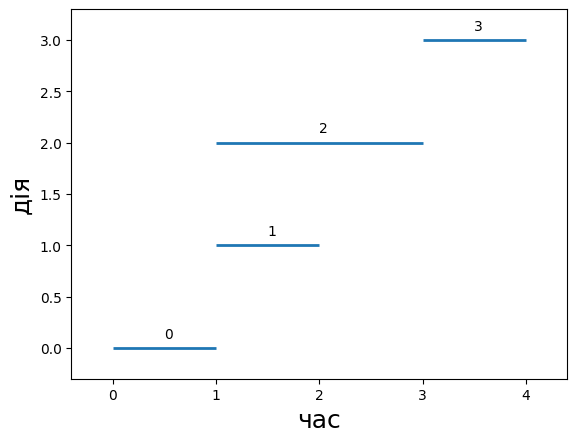

In [51]:
visualize_solution(tracker['optimal_bitstring'])

#Brute force

In [52]:
Q_without_resource_constraints = np.zeros((number_of_variables, number_of_variables))
offset_without_resource_constraints = 0.0
add_objective_function(Q_without_resource_constraints, end_activity)
offset_without_resource_constraints = add_activity_one_start_penalty(Q_without_resource_constraints, offset_without_resource_constraints, one_start_penalty)
add_precedence_penalty(Q_without_resource_constraints, precedence_penalty)

In [53]:
def check_resourse_constraints(x):
    for t in range(0, latest_start[end_activity]+1):
        for k in range(0, number_of_recourses):
            consuption = 0
            for i in range(0, num_activities):
                    for r in range(max(t - activity_processing_time[i] + 1, earliest_start[i]), min(t, latest_start[i])+1):
                        consuption += resourse_consumption[i, k] * x[activity_time_to_index(i, r)]
            if consuption > resourse_capacity[k]:
                return False
    return True

In [54]:
def Q_true_cost(x):
    cost = x @ Q_without_resource_constraints @ x + offset_without_resource_constraints
    if not check_resourse_constraints(x):
        cost += 100
    return cost

In [55]:
def brute_force_sol(Q):
    opt_x = np.array([0] * int(Q.shape[0]))
    minimal_energy = (opt_x.T @ Q @ opt_x) + qubo_offset
    maximum_opt_energy = None
    minumum_true_cost = Q_true_cost(opt_x)
    for bitstr in itertools.product([0, 1], repeat=number_of_variables):
        x = np.array(bitstr)
        energy = (x.T @ Q @ x) + qubo_offset
        if energy < minimal_energy:
            minimal_energy = energy
            opt_x = x
        true_cost = Q_true_cost(x)
        if true_cost < minumum_true_cost or (np.allclose(minumum_true_cost, true_cost) and (maximum_opt_energy is None or maximum_opt_energy < energy)):
            minumum_true_cost = true_cost
            maximum_opt_energy = energy
    return opt_x, minumum_true_cost, minimal_energy, maximum_opt_energy

you can use it like this

In [56]:
# opt_x, minumum_true_cost, minimal_energy, maximum_opt_energy = brute_force_sol(Q)
# print(opt_x)
# print(minumum_true_cost)
# print(minimal_energy)
# print(maximum_opt_energy)

you can after that find all optimal solutions with that true cost

In [57]:
def all_sol_with_optimal_cost(optimal_cost):
    solutions = []
    for bitstr in itertools.product([0, 1], repeat=number_of_variables):
        x = np.array(bitstr)
        cost_without_resource_constraints = x @ Q_without_resource_constraints @ x + offset_without_resource_constraints
        if np.allclose(cost_without_resource_constraints, optimal_cost):
            if check_resourse_constraints(x):
                solutions.append(x)
    return solutions

In [58]:
opt_solutions = all_sol_with_optimal_cost(3.0)

In [59]:
opt_solutions

[array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])]